In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from tqdm.auto import tqdm

from matplotlib import cm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

jet = cm.get_cmap('jet')

/tmp/ipykernel_95549/1764591451.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


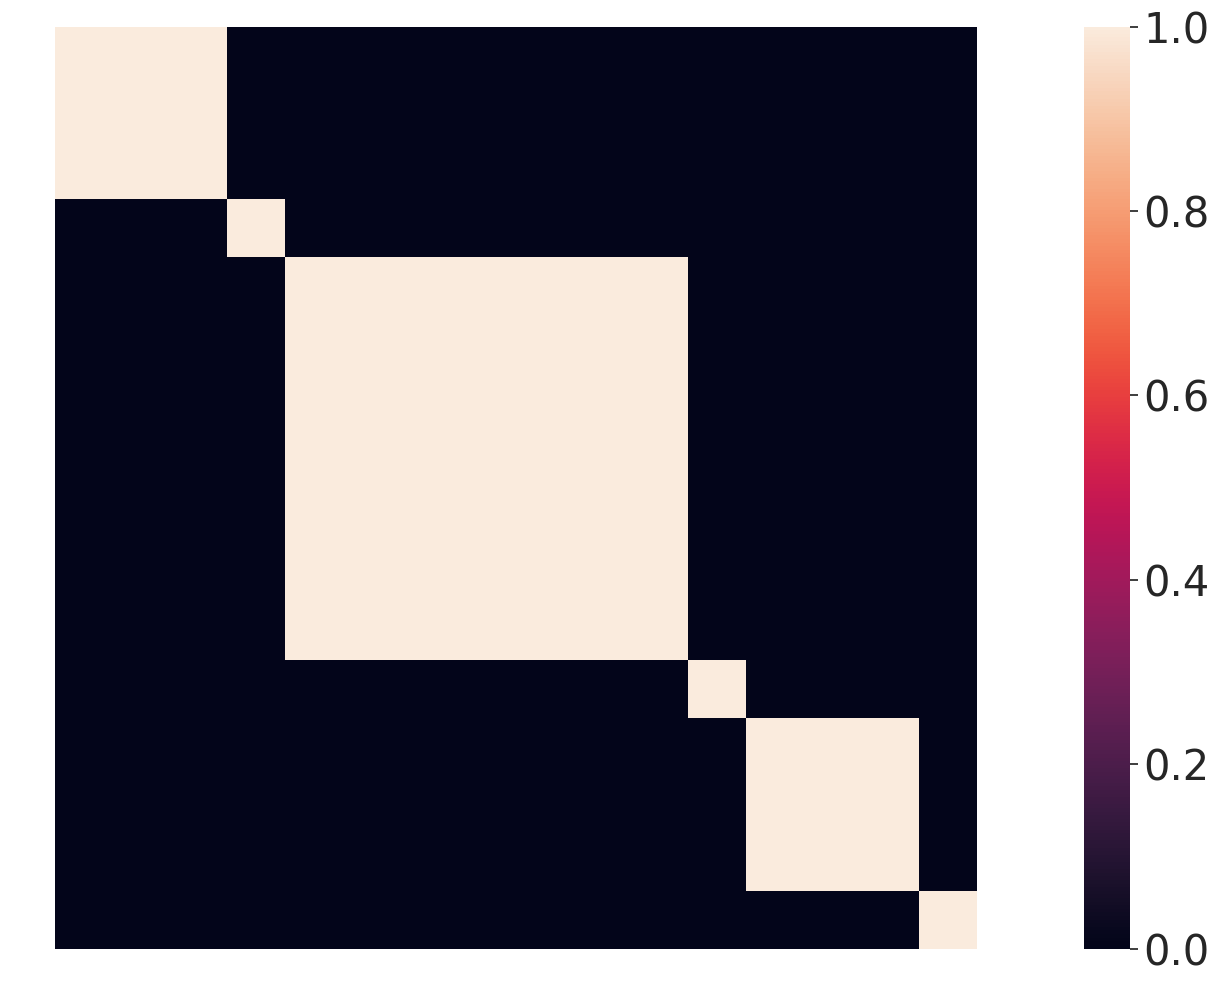

In [35]:
Y0 = torch.tensor([[0,0,0,0,0,0,0,1,1,0,0,0,1,0,0],
                   [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
                   [0,0,0,0,0,0,1,1,1,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,1,1,1,1,1,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1]])

Y2 = torch.tensor([[1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

Y1 = torch.tensor([[1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1]])


Ys = [Y0,Y1,Y2]

Y_idx = 2

Y = Ys[Y_idx]

c, n = Y.shape

fig = plt.figure(figsize=(13,10))
ax = sns.heatmap((Y.T @ Y).detach().cpu())
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
#cbar.set_ticks([0, 0.5, 1.0])
plt.axis("equal")
plt.axis("off")
plt.tight_layout()
fig.savefig(f"./Y{Y_idx}_{c}x{n}.pdf", bbox_inches="tight")

# Ours

Train:   0%|          | 0/1000 [00:00<?, ?it/s]

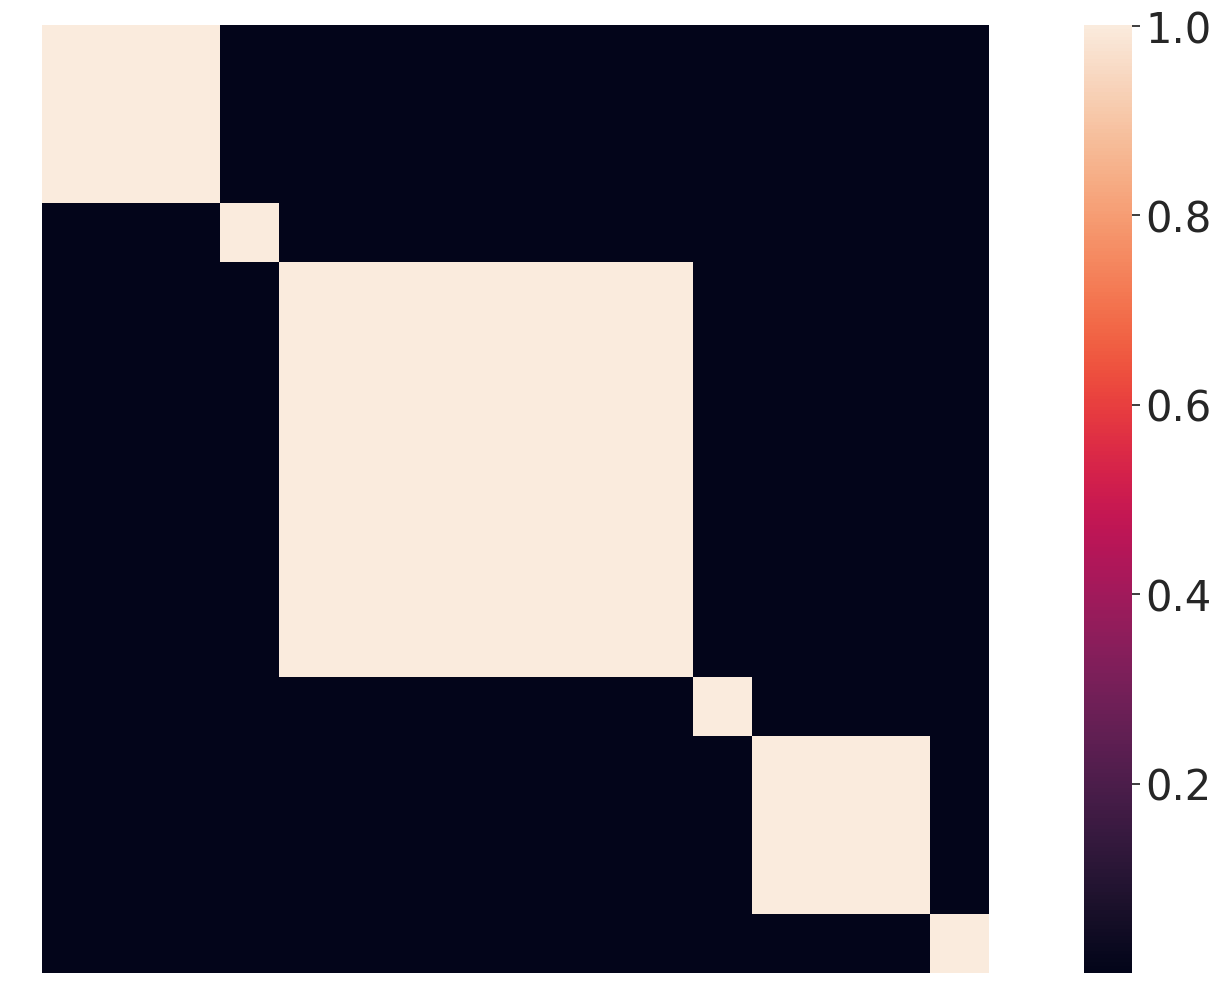

In [36]:
device = "cpu"

X = torch.normal(0, 0.01, size=(10, n), requires_grad=True)

alpha = 0.99
beta  = 0.7
niter = 1000

tracker = {'loss' : [], 'x_svals' : []}
bar = tqdm(total=niter, dynamic_ncols=True, desc='Train')

optimizer = optim.SGD([X], lr=0.5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.995)
X = X.to(device)
Y = Y.to(device)

for i in range(niter):
    optimizer.zero_grad()

    Z = torch.cat((Y, X), dim=0)
    z_svals = torch.linalg.svdvals(Z)
    x_svals = torch.linalg.svdvals(X)
    z_nuc = z_svals.sum()
    x_nuc = x_svals.sum()
    loss = z_nuc - alpha * x_nuc + beta * x_svals.max() ** 2

    loss.backward()
    tracker['loss'].append(loss.detach().item())
    tracker['x_svals'].append(x_svals.detach().sort()[0])

    bar.set_postfix(loss="{:1.5e}".format(loss.detach().item()),
                    lr="{:1.3e}".format(scheduler.get_last_lr()[0]))
    bar.update()
    optimizer.step()
    scheduler.step()
bar.close()

tracker["x_svals"] = torch.stack(tracker["x_svals"], dim=0)

fig = plt.figure(figsize=(13,10))
ax = sns.heatmap((F.normalize(X, dim=0, p=2).T @ F.normalize(X, dim=0, p=2)).detach().cpu() ** 2)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.axis("equal")
plt.axis("off")
plt.tight_layout()
#fig.savefig(f"./Y{Y_idx}_ours_{c}x{n}.pdf", bbox_inches="tight")

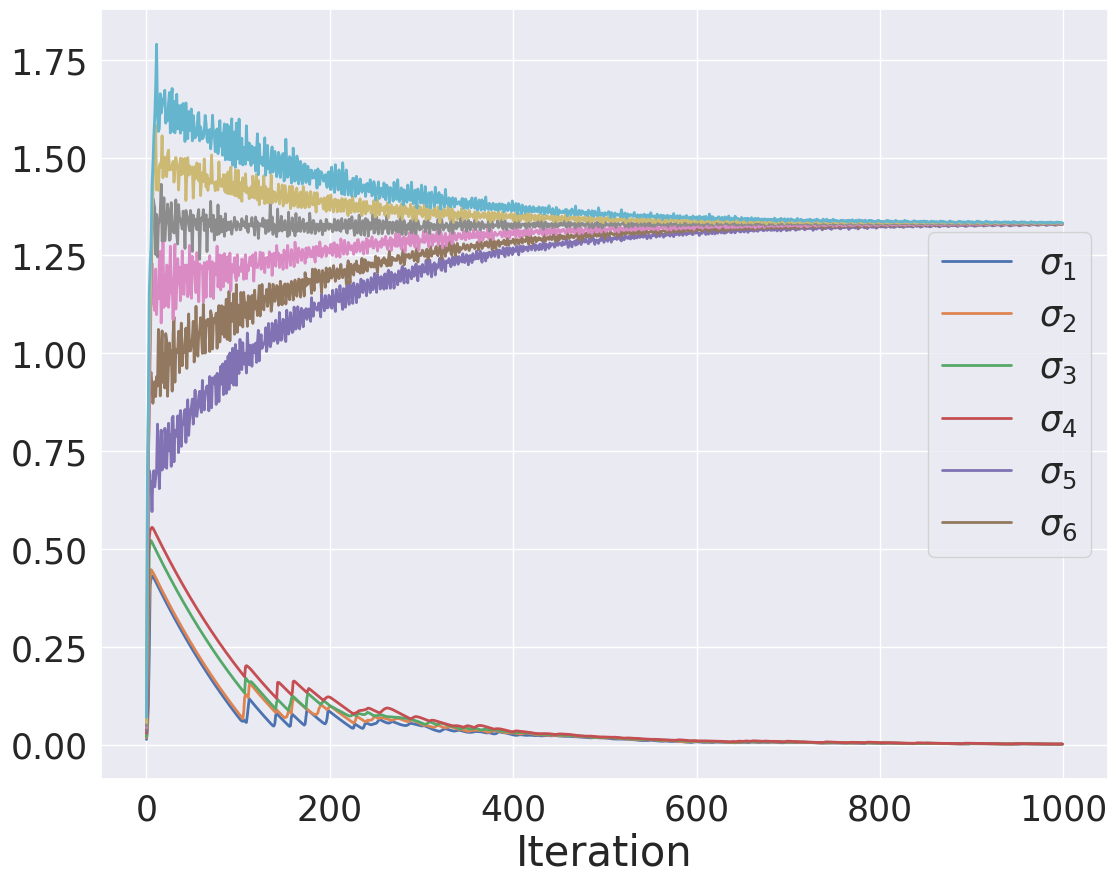

In [37]:
fig = plt.figure(figsize=(13,10))
plt.plot(tracker["x_svals"], linewidth=2)
plt.legend([f"$\sigma_{i+1}$" for i in range(c)], fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("Iteration", fontsize=30)
fig.savefig(f"./convergence_Y{Y_idx}.pdf")

# OLE

Train:   0%|          | 0/1500 [00:00<?, ?it/s]

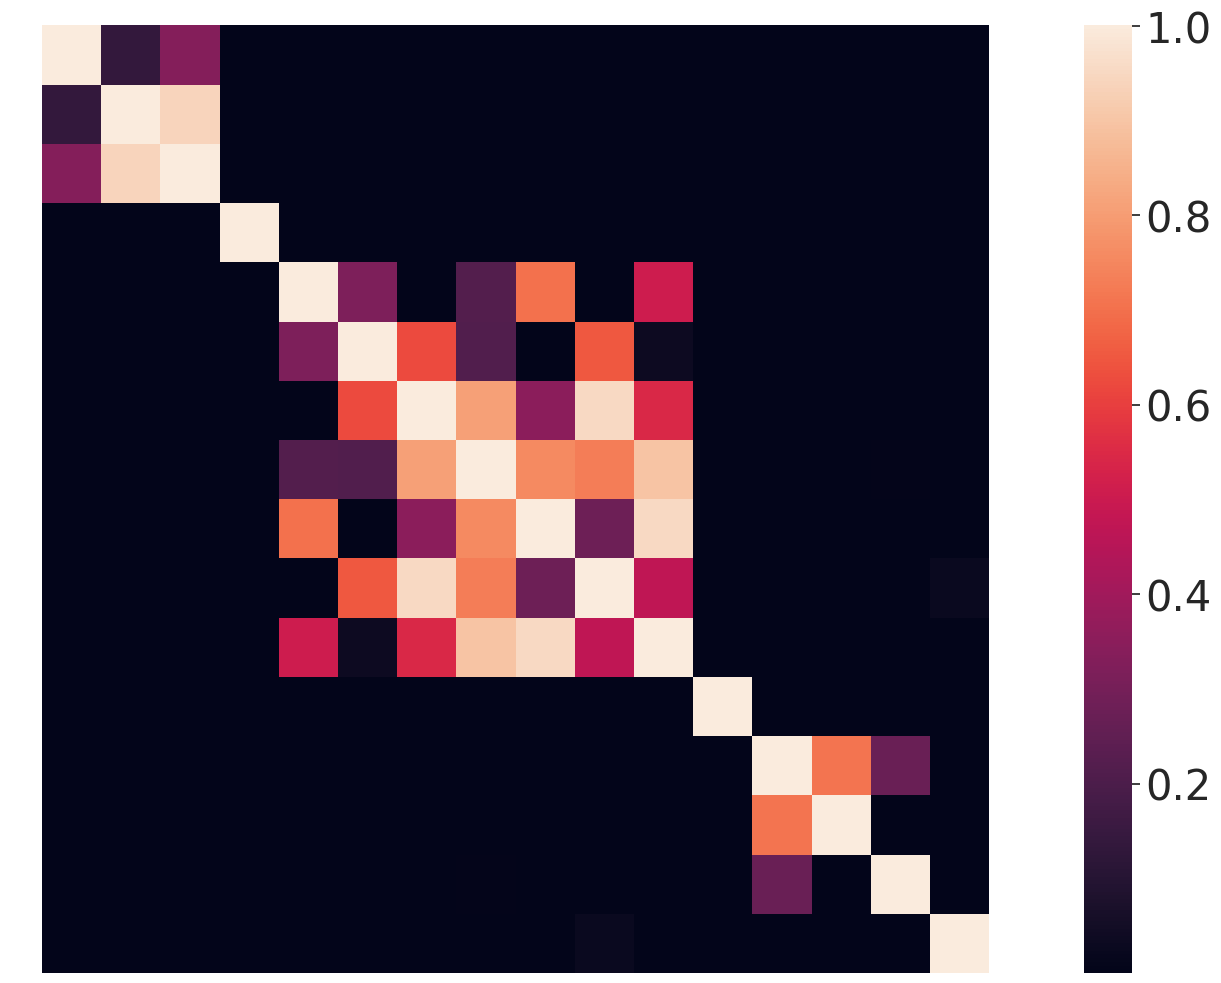

In [55]:
X = torch.normal(0, 0.01, size=(10, n), requires_grad=True)

niter = 1500

tracker = {'loss' : [], 'x_svals' : []}
bar = tqdm(total=niter, dynamic_ncols=True, desc='Train')

optimizer = optim.SGD([X], lr=0.1)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
X = X.to(device)
Y = Y.to(device)

for i in range(niter):
    optimizer.zero_grad()

    x_svals = torch.linalg.svdvals(X)
    class_nuclear_norms = []

    for label in range(c):
        mask = Y[label,:] == 1
        class_svdvals = torch.linalg.svdvals(X[:,mask])
        class_nuclear_norms.append(torch.max(torch.tensor(1.0), class_svdvals.sum()))
    loss = sum(class_nuclear_norms) - x_svals.sum()

    loss.backward()
    tracker['loss'].append(loss.detach().item())
    tracker['x_svals'].append(x_svals.detach().sort()[0])

    bar.set_postfix(loss="{:1.5e}".format(loss.detach().item()),
                    lr="{:1.3e}".format(scheduler.get_last_lr()[0]))
    bar.update()
    optimizer.step()
    scheduler.step()
bar.close()

tracker["x_svals"] = torch.stack(tracker["x_svals"], dim=0)

fig = plt.figure(figsize=(13,10))
ax = sns.heatmap((F.normalize(X, dim=0, p=2).T @ F.normalize(X, dim=0, p=2)).detach().cpu() ** 2)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.axis("equal")
plt.axis("off")
plt.tight_layout()
fig.savefig(f"./Y{Y_idx}_ole_{c}x{n}.pdf", bbox_inches="tight")

# MCMR

Train:   0%|          | 0/1500 [00:00<?, ?it/s]

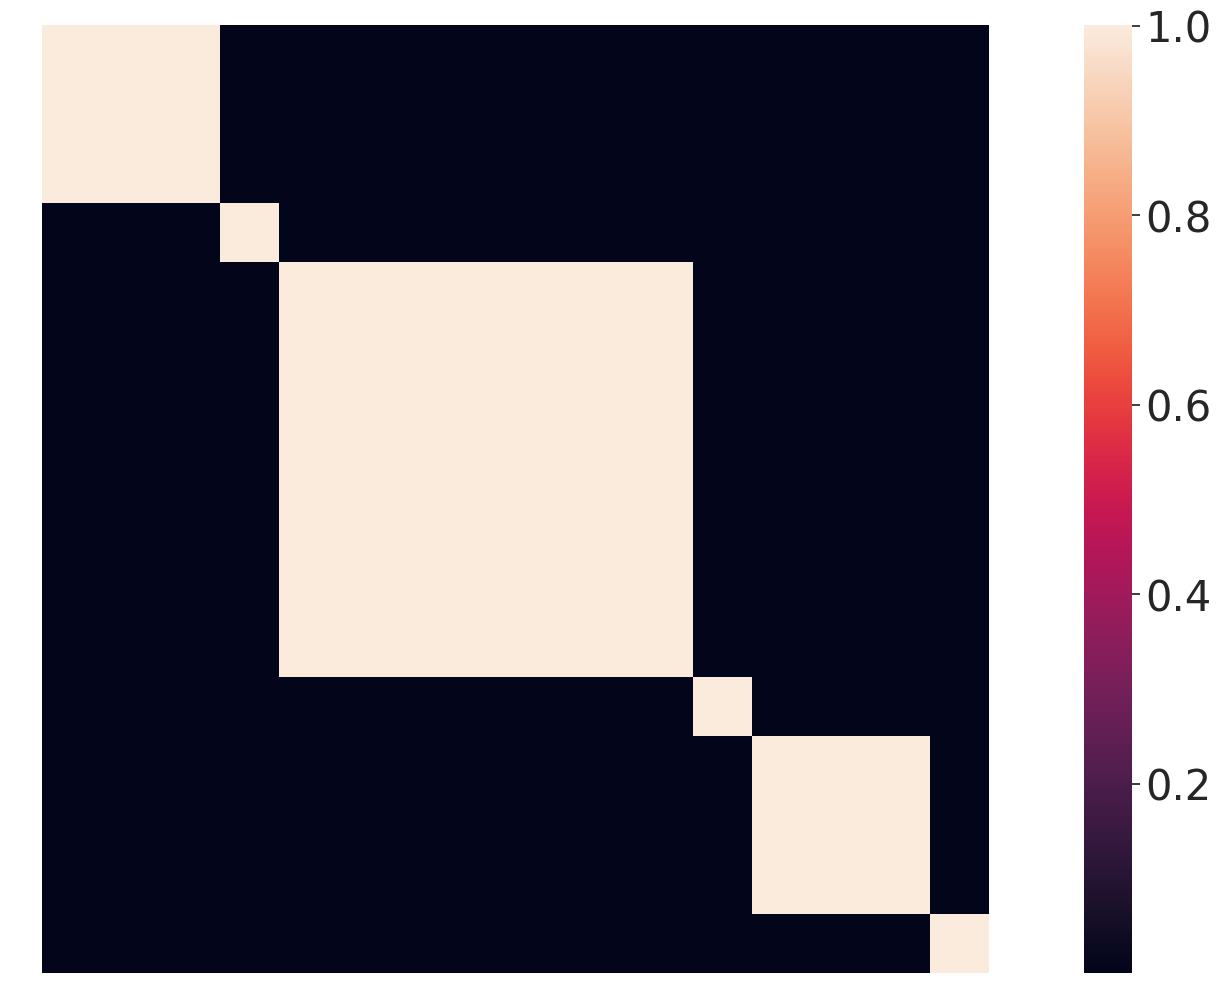

In [56]:
X = torch.normal(0, 0.01, size=(6, n), requires_grad=True)

niter = 1500

tracker = {'loss' : [], 'x_svals' : []}
bar = tqdm(total=niter, dynamic_ncols=True, desc='Train')

optimizer = optim.SGD([X], lr=0.1)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
X = X.to(device)
Y = Y.to(device)

for i in range(niter):
    optimizer.zero_grad()
    C = []
    X_normed = F.normalize(X, dim=0, p=2)
    for label in range(c):
        mask = Y[label,:] == 1
        C.append(X[:,mask].mean(dim=-1))
    C = torch.stack(C, dim=-1)
    loss = -torch.linalg.svdvals(C).sum()

    loss.backward()
    tracker['loss'].append(loss.detach().item())
    tracker['x_svals'].append(x_svals.detach().sort()[0])

    bar.set_postfix(loss="{:1.5e}".format(loss.detach().item()),
                    lr="{:1.3e}".format(scheduler.get_last_lr()[0]))
    bar.update()
    optimizer.step()
    scheduler.step()
bar.close()

tracker["x_svals"] = torch.stack(tracker["x_svals"], dim=0)

fig = plt.figure(figsize=(13,10))
ax = sns.heatmap((F.normalize(X, dim=0, p=2).T @ F.normalize(X, dim=0, p=2)).detach().cpu() ** 2)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.axis("equal")
plt.axis("off")
plt.tight_layout()
fig.savefig(f"./Y{Y_idx}_mcmr_{c}x{n}.pdf", bbox_inches="tight")